# Walmart Stock Arima Model
- *Darlene Adams*

Imports and Custom Functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn import set_config

from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs

import statsmodels.tsa.api as tsa
import itertools

plt.rcParams['figure.figsize']=(12,3)

import warnings
warnings.filterwarnings("ignore")

In [2]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None,
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)

    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index,
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();

    return fig, ax

In [3]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d,
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags,
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [4]:
def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [5]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5),
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},
                  annotate_seas=False, m = None,
                 seas_color='black'):

    fig, axes = plt.subplots(nrows=2, figsize=figsize)


    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)

    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)

    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)




    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)

        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()

    return fig

## Load and Prep Data

In [6]:
# load the data
df = pd.read_csv('Data\WMT.csv')
df.head()

,Date,Adj Close
0,2000-01-03,44.915394
1,2000-01-04,43.234756
2,2000-01-05,42.352402
3,2000-01-06,42.814564
4,2000-01-07,46.049828


In [7]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date']

0      2000-01-03
1      2000-01-04
2      2000-01-05
3      2000-01-06
4      2000-01-07
          ...    
5474   2020-12-25
5475   2020-12-28
5476   2020-12-29
5477   2020-12-30
5478   2020-12-31
Name: Date, Length: 5479, dtype: datetime64[ns]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5479 entries, 0 to 5478
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5479 non-null   datetime64[ns]
 1   Adj Close  5284 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 85.7 KB


In [9]:
df = df.set_index('Date')
df.index
df.head()

,Adj Close
Date,
2000-01-03,44.915394
2000-01-04,43.234756
2000-01-05,42.352402
2000-01-06,42.814564
2000-01-07,46.049828


In [10]:
# resample for business day with 'B'
df = df.resample('B').asfreq()

In [11]:
# Check for nulls
df.isna().sum()

Adj Close    195
dtype: int64

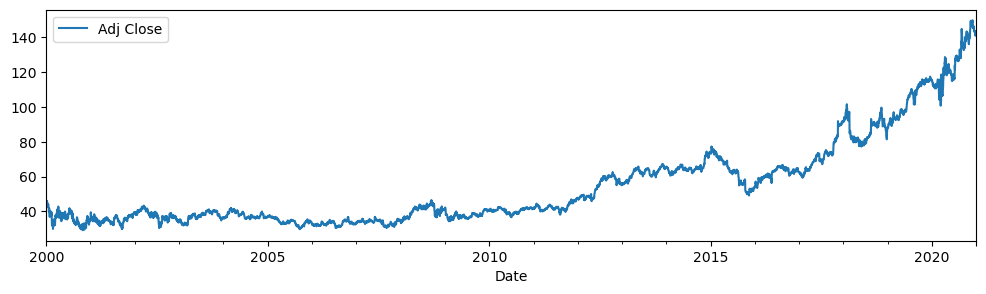

In [13]:
# forwardfill nulls
df = df.ffill()
df.plot();

In [14]:
df.isna().sum()

Adj Close    0
dtype: int64

In [15]:
# using ADF to evaluate for stationarity
get_adfuller_results(df)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,2.45764,32,5446,0.999035,0.05,False


In [16]:
# use ndiffs to get differencing
d = ndiffs(df)
d

2

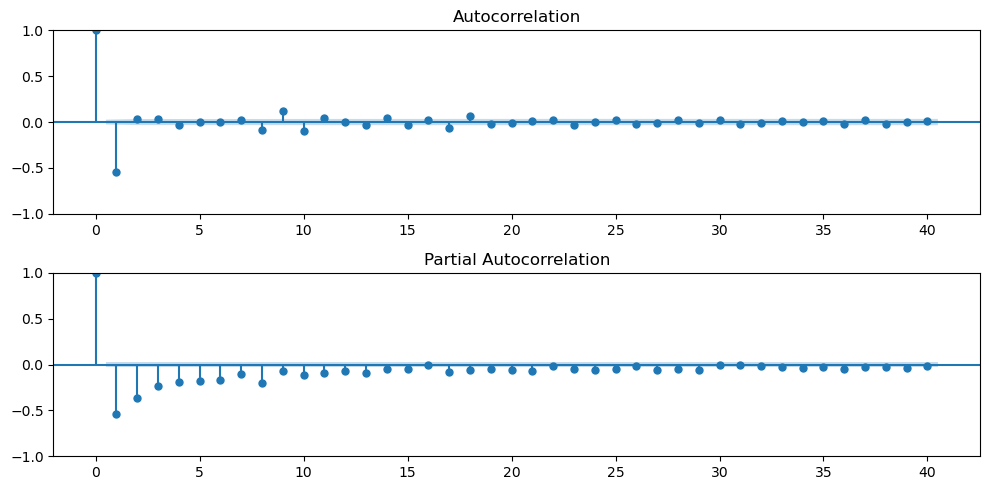

In [17]:
df_diff2 =df.diff().diff().dropna()
plot_acf_pacf(df_diff2);

# Train Test Split

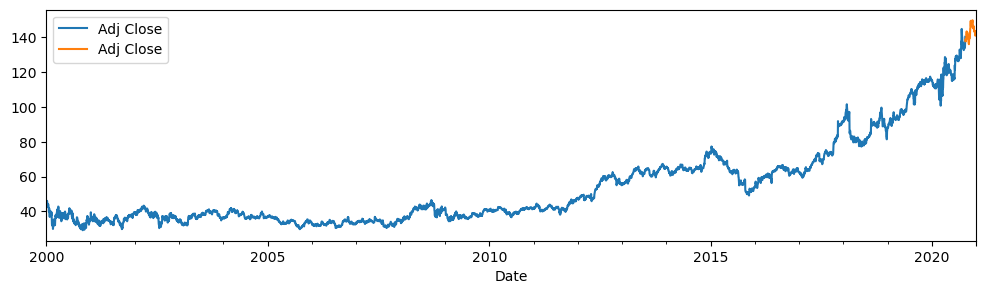

In [18]:
# calculate the number of test lags
n_test_lags = 5*13

# modeling
train, test = train_test_split(df, test_size=n_test_lags)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

## Modeling

In [19]:
# build the model
p = 0
d = 2
q =  1

# Define and fit
arima_model = tsa.ARIMA(train, order=(p,d,q)).fit()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 2.720
- MSE = 12.227
- RMSE = 3.497
- R^2 = 0.049
- MAPE = 1.88%


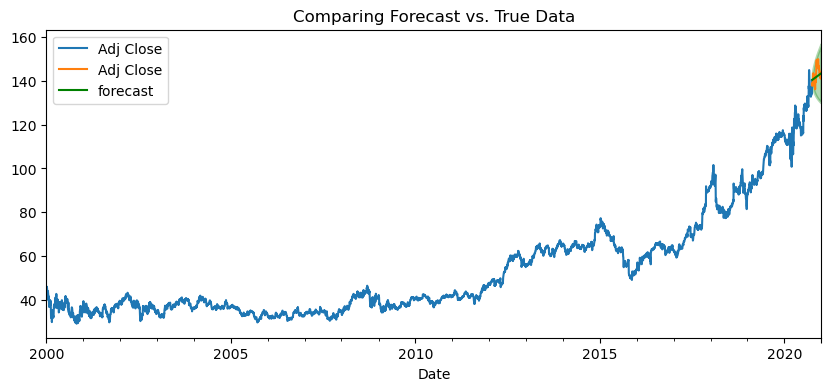

In [20]:
# summary of forecast as dataframe
forecast_df = arima_model.get_forecast(len(test)).summary_frame()

# Plot the forecast
plot_forecast(train, test, forecast_df)

# get metrics
regression_metrics_ts(test, forecast_df['mean'])

In [21]:
# model summary
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 5414
Model:                 ARIMA(0, 2, 1)   Log Likelihood               -6682.931
Date:                Mon, 04 Dec 2023   AIC                          13369.863
Time:                        18:28:27   BIC                          13383.056
Sample:                    01-03-2000   HQIC                         13374.468
                         - 10-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9993      0.001  -1592.459      0.000      -1.000      -0.998
sigma2         0.6911      0.003    220.357      0.000       0.685       0.697
===================================================================================
Ljung-Box (L1) (Q):                  50.45   Jarque-Bera (JB):            265913.19
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.15   Skew:                             1.07
Prob(H) (two-sided):                  0.00   Kurtosis:                        37.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

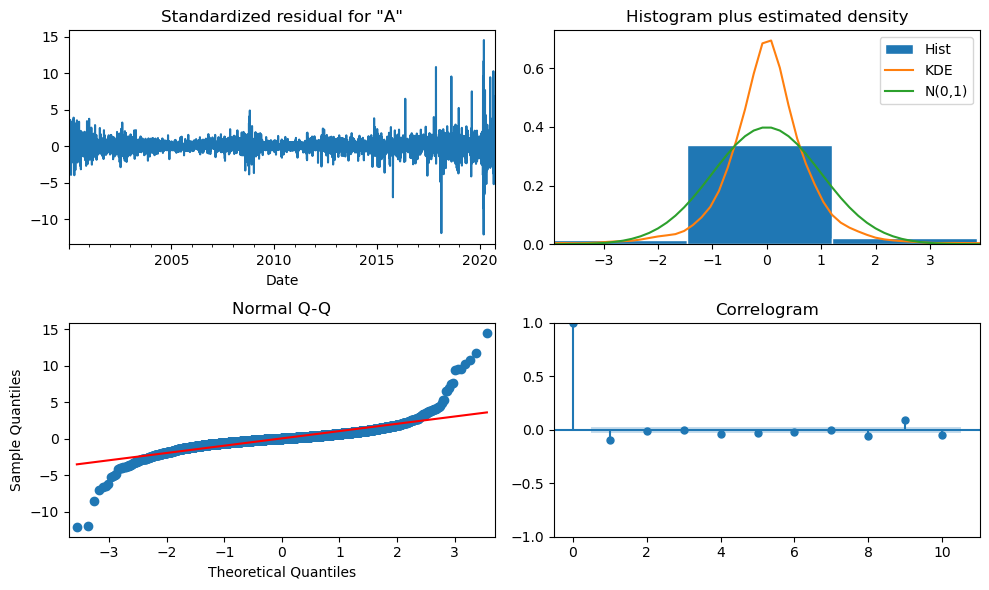

In [22]:
# diagnostic plots
fig = arima_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

## Loop for different models

In [23]:
# Define the value or range of values for p, d, q
p_values = range(0, 4)
d_values = [2]
q_values = range(0, 4)

# Create combinations of pdq to test
pdq_to_try = list(itertools.product(p_values, d_values, q_values))

pdq_to_try

[(0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (0, 2, 3),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (1, 2, 3),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2),
 (2, 2, 3),
 (3, 2, 0),
 (3, 2, 1),
 (3, 2, 2),
 (3, 2, 3)]

In [24]:
# define starting aic as infinity
best_aic = float('inf')

# define baseline for pdq
best_pdq = (0, 0, 0)

# loop through each combination
for pdq in pdq_to_try:
    model = tsa.ARIMA(train, order = pdq)
    result = model.fit()
    print(pdq, result.aic)

    # if lower, replace best AIC with new value
    if result.aic < best_aic:
        best_aic = result.aic
        best_pdq = pdq

# priont the best orders and AIC score
print("Best AIC:", best_aic)
print("Best pdq:", best_pdq)

(0, 2, 0) 17599.851772173064
(0, 2, 1) 13369.86282710109
(0, 2, 2) 13319.347175724775
(0, 2, 3) 13320.34400762716
(1, 2, 0) 15737.030328265622
(1, 2, 1) 13321.060555352105
(1, 2, 2) 13373.862431850954
(1, 2, 3) 13315.57583587142
(2, 2, 0) 14997.342386606297
(2, 2, 1) 13320.896147617645
(2, 2, 2) 13315.182874348604
(2, 2, 3) 13318.13429415179
(3, 2, 0) 14685.116539544819
(3, 2, 1) 13322.56001590827
(3, 2, 2) 13317.17625262733
(3, 2, 3) 13295.951603822163
Best AIC: 13295.951603822163
Best pdq: (3, 2, 3)


In [25]:
# build model with best AIC
p = 3
d = 2
q = 3

# define and fit the model
ar_2_ma_3_model = tsa.ARIMA(train, order=(p,d,q)).fit()

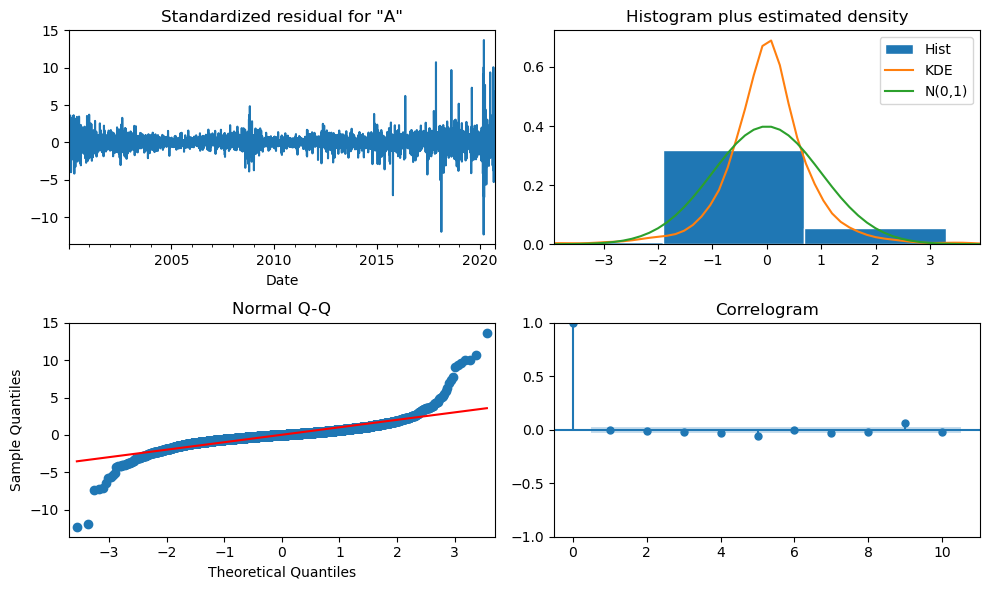

In [26]:
# Obtain diagnostic plots
fig = ar_2_ma_3_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 2.877
- MSE = 14.176
- RMSE = 3.765
- R^2 = -0.102
- MAPE = 1.98%


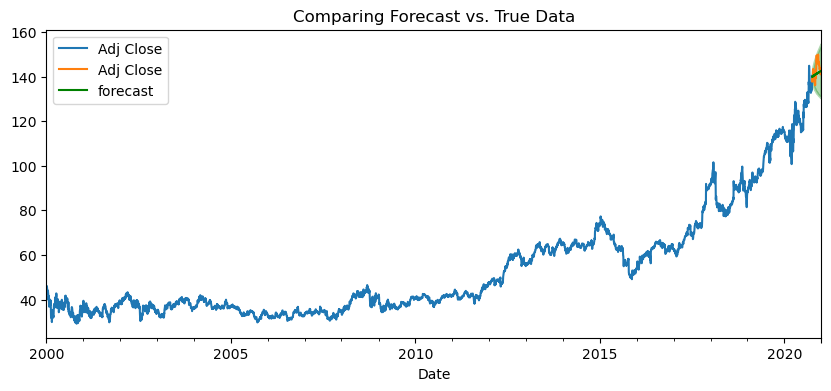

In [27]:
# Get summary of forecast as dataframe
forecast_df = ar_2_ma_3_model.get_forecast(len(test)).summary_frame()
# Plot forecast with true values
plot_forecast(train, test, forecast_df)
# Getmetrics
regression_metrics_ts(test, forecast_df['mean'])

# Compare Models

**Model 1 (0,2,1)**

- MAE = 2.720
- MSE = 12.227
- RMSE = 3.497
- R^2 = 0.049
- MAPE = 1.88%

**Model 2 (3,2,3)**

- MAE = 2.877
- MSE = 114.176
- RMSE = 3.765
- R^2 = -0.102
- MAPE = 1.98%

### The model that performed the best was model 1 (0,2,1)

How good was the model, according to the Mean Absolute Percentage Error?

Mean Absolute Percentage Error is

How good was the model in terms of how well the forecast seems to follow the test data, visually

Visually the forecast model appears to follow the test data well
